# Cleaning up the data and doing some visualization.

Right by looking at the data we see that age and time is weird looking...

In [277]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_style("darkgrid")

In [278]:
df = pd.read_csv("train.csv")
df.head().T

,0,1,2,3,4
AnimalID,A671945,A656520,A686464,A683430,A667013
Name,Hambone,Emily,Pearce,NaN,NaN
DateTime,2014-02-12 18:22:00,2013-10-13 12:44:00,2015-01-31 12:28:00,2014-07-11 19:09:00,2013-11-15 12:52:00
OutcomeType,Return_to_owner,Euthanasia,Adoption,Transfer,Transfer
OutcomeSubtype,NaN,Suffering,Foster,Partner,Partner
AnimalType,Dog,Cat,Dog,Cat,Dog
SexuponOutcome,Neutered Male,Spayed Female,Neutered Male,Intact Male,Neutered Male
AgeuponOutcome,1 year,1 year,2 years,3 weeks,2 years
Breed,Shetland Sheepdog Mix,Domestic Shorthair Mix,Pit Bull Mix,Domestic Shorthair Mix,Lhasa Apso/Miniature Poodle
Color,Brown/White,Cream Tabby,Blue/White,Blue Cream,Tan


# Note that there are only certain columns in the testing data

in particular outcome subtype is missing. there are ways we can use that in our data to control for it in the testing. If for example $P(subtype|type)$ changes between the training and test. lets assume its not for now.

we basically then just have:

    Name: factor
    DateTime: datetime
    AnimalType: factor
    SexuponOutcome: factor
    AgeuponOutcome: factor
    Breed: factor
    Color: factor

    
My goal is to do the following:

    1. split sexupon into two terms, (sex|reproduce)
    2. turn the Age upon into a number and do some analysis.
    3. turn breed into a TFIDF Matrix
    4. turn colour into a Count Matrix

## Cleaning SexuponOutcome

In [279]:
df["sex_male"] = df["SexuponOutcome"].replace({
        "Neutered Male":1,
        "Intact Male":1,
        "Spayed Female":0,
        "Intact Female":0,
        "Unknown":2
    })

df["sex_active"] = df["SexuponOutcome"].replace({
        "Neutered Male":0,
        "Intact Male":1,
        "Spayed Female":0,
        "Intact Female":1,
        "Unknown": 2
    })

In [280]:
t = df.groupby(["SexuponOutcome", "OutcomeType"]).count()["AnimalID"].unstack().T
t / t.sum()

SexuponOutcome,Intact Female,Intact Male,Neutered Male,Spayed Female,Unknown
OutcomeType,,,,,
Adoption,0.057818,0.044823,0.534001,0.587982,NaN
Died,0.015950,0.022411,0.001943,0.002041,0.022873
Euthanasia,0.114212,0.135319,0.035177,0.026304,0.092406
Return_to_owner,0.085731,0.135319,0.229778,0.198186,0.010979
Transfer,0.726289,0.662128,0.199100,0.185488,0.873742


In [281]:
df.groupby("OutcomeType").mean().T

OutcomeType,Adoption,Died,Euthanasia,Return_to_owner,Transfer
sex_male,0.499582,0.751269,0.657878,0.574295,0.657079
sex_active,0.033522,0.939086,0.694534,0.167607,0.721078


# Cleaning up AgeUpon


Here we just convert ageupon to dates and then take the log since we notice some power law effects.

In [282]:
ages = df["AgeuponOutcome"].str.split(" ")

to_days = {
    "year":365,
    "years": 365,
    "week": 7,
    "weeks": 7,
    "month": 30,
    "months": 30,
    "day": 1,
    "days": 1
}

ages[ages.notnull()] = ages[ages.notnull()].apply(lambda d: int(d[0]) * to_days[d[1]])
ages = ages.fillna(0) + 1 


df["age"] = ages
df["age_log"] = np.log(ages)

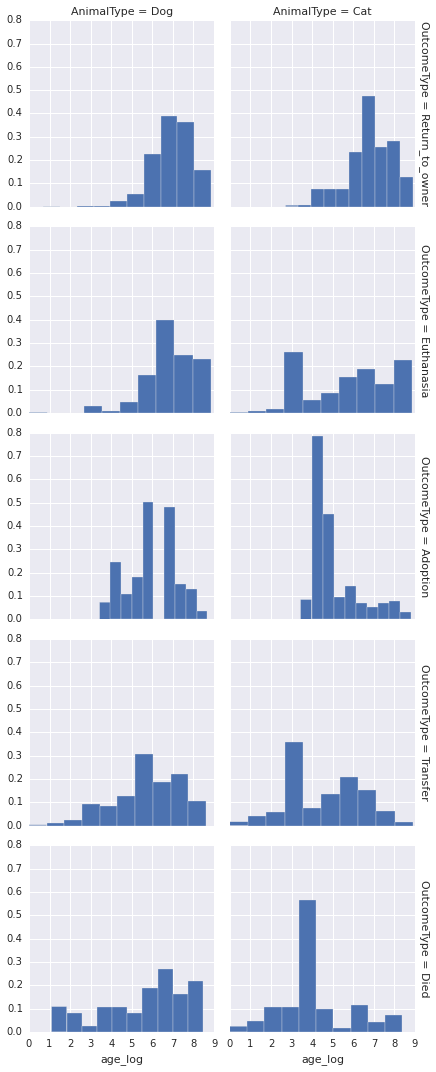

In [284]:
g = sns.FacetGrid(df, col="AnimalType",  row="OutcomeType",  size=3, margin_titles=1)
g.map(plt.hist, "age_log", bins=10, normed=1)

# Clean up DateTime

In [285]:
df.index = pd.to_datetime(df["DateTime"])

In [286]:
def plot(gby, title):
    t = df.groupby([gby, "OutcomeType"]).count()["AnimalID"].unstack()
    t = t / t.sum()
    t.plot(subplots=(5,1), figsize=(12,10), title=title)

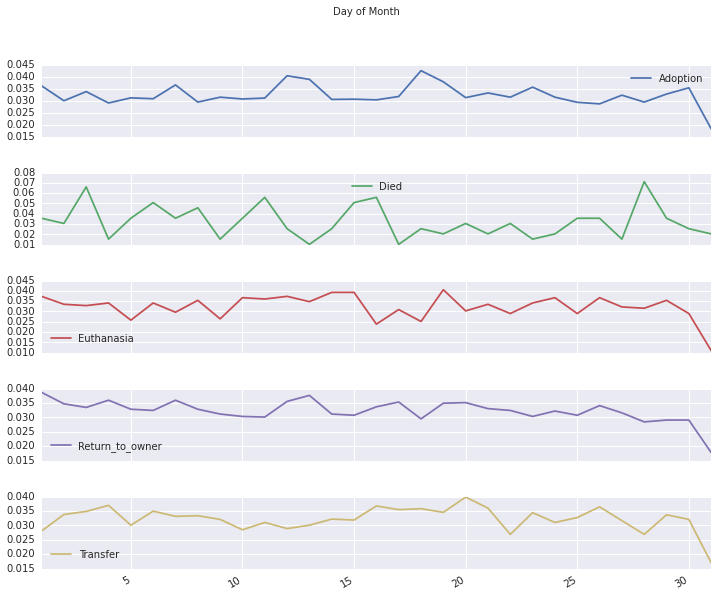

In [287]:
plot(df.index.day, "Day of Month")

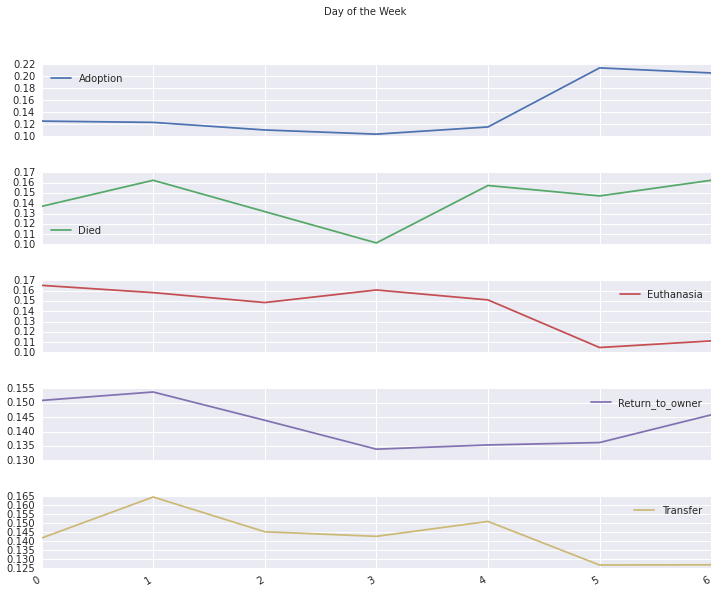

In [288]:
plot(df.index.dayofweek, "Day of the Week")

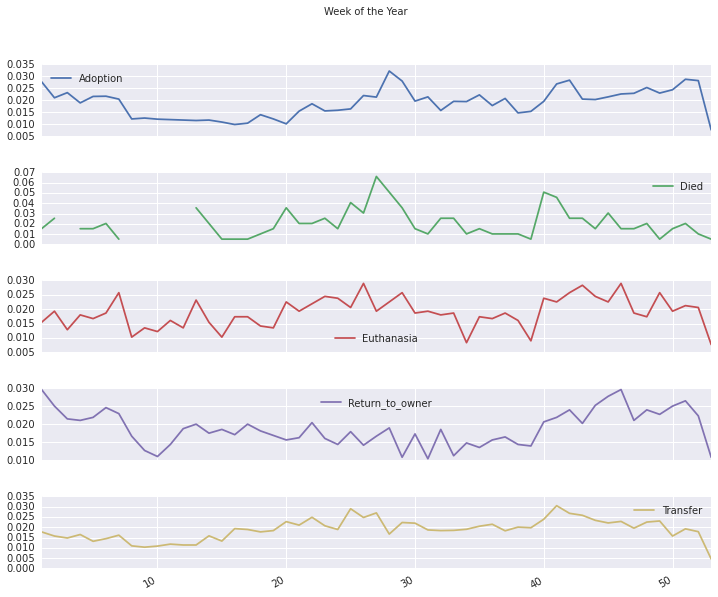

In [289]:
plot(df.index.weekofyear, "Week of the Year")

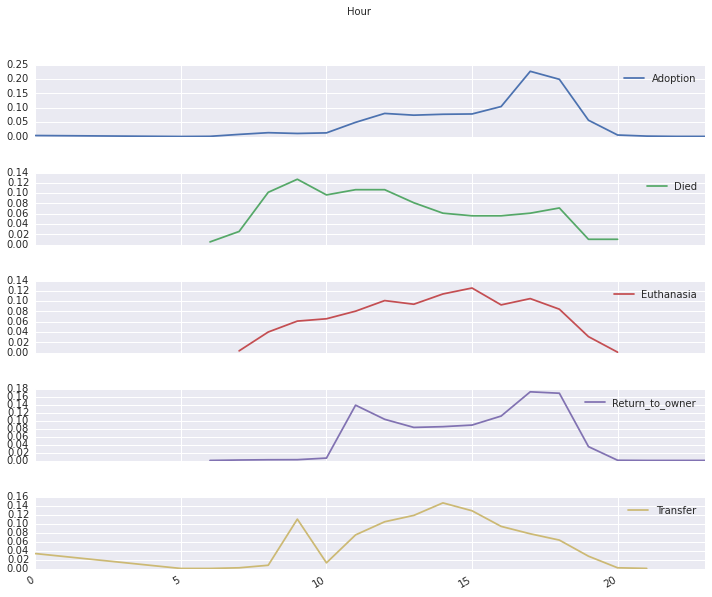

In [290]:
plot(df.index.hour, "Hour")

In [291]:
df["time_dof_month"] = df.index.day
df["time_dof_year"] = df.index.dayofyear
df["time_dof_week"] = df.index.dayofweek
df["time_week"] = df.index.weekofyear
df["time_month"] = df.index.month
df["time_hour"] = df.index.hour

# Missing at Random?

Sometimes the fact that the data is missing means something for example not reviewing a movie probably means you didnt like it.

In [299]:
t = df.groupby([df.Name.isnull(), "OutcomeType"]).count()["AnimalID"].unstack().T
t = t/t.sum()
t

Name,False,True
OutcomeType,,
Adoption,0.477519,0.218177
Died,0.004045,0.015603
Euthanasia,0.038870,0.105968
Return_to_owner,0.243355,0.019893
Transfer,0.236212,0.640359


The table above is $P(outcome|name==null)$, we see that if the name is missing it might because you were transfered. Also if the name is missing you probably didnt return it to the owner nor did it die.

In [303]:
t = df.groupby([df.AgeuponOutcome.isnull(), "OutcomeType"]).count()["AnimalID"].unstack().T
t = t/t.sum()
t.fillna(0)

AgeuponOutcome,False,True
OutcomeType,,
Adoption,0.403167,0.000000
Died,0.007375,0.000000
Euthanasia,0.058141,0.111111
Return_to_owner,0.179177,0.000000
Transfer,0.352140,0.888889


The table above is $P(outcome|age==null)$, we see that if the name is missing it might because you were transfered. Also if the name is missing you probably didnt return it to the owner nor did it die.

# Data is missing when the animal if transfered.

In [304]:
df["missing_name"] = df.Name.isnull()
df["missing_age"] = df.AgeuponOutcome.isnull()

In [306]:
df.sample(4).T

DateTime,2015-12-23 13:34:00,2014-08-22 09:00:00,2014-12-04 12:27:00,2015-04-06 12:26:00
AnimalID,A716700,A686409,A690614,A699452
Name,Smudge,NaN,Morris,Benito
DateTime,2015-12-23 13:34:00,2014-08-22 09:00:00,2014-12-04 12:27:00,2015-04-06 12:26:00
OutcomeType,Transfer,Transfer,Transfer,Adoption
OutcomeSubtype,Partner,SCRP,Partner,NaN
AnimalType,Cat,Cat,Cat,Dog
SexuponOutcome,Spayed Female,Intact Male,Neutered Male,Neutered Male
AgeuponOutcome,2 years,4 months,2 months,2 years
Breed,Domestic Shorthair Mix,Domestic Shorthair Mix,Domestic Shorthair Mix,Chihuahua Longhair Mix
Color,Blue Tabby/White,Blue,Black,White/Black


# TODO:

I'd like to also tfidf the breed, colour and name. 